In [111]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd;
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import statsmodels.api as sm

class univariate_ts_rnn:
    def __init__(self,
                 time_steps=10,
                hidden_layers=14,
                epochs=50,
                loss_stopping_patience=20,
                batch_size=15,
                verbose=2,
                loss_curve=True,
                forecast_eval=True,
                activation=['tanh', 'tanh'],
                split=0.75,
                normalize=True,
                learning_rate=0.001,
                return_predictions=True
                ):
        self.time_steps=time_steps
        self.hidden_layers=hidden_layers
        self.epochs=epochs
        self.loss_stopping_patience=loss_stopping_patience
        self.batch_size=batch_size
        self.verbose=verbose
        self.loss_curve=loss_curve
        self.forecast_eval=forecast_eval
        self.split=split
        self.activation=activation
        self.normalize=normalize
        self.learning_rate=learning_rate
        self.return_predictions=return_predictions
    
    def create_RNN(hidden_units, dense_units, input_shape, activation):
        model = Sequential()
        model.add(SimpleRNN(hidden_units, 
                            input_shape=input_shape, 
                            activation=activation[0]))
        model.add(Dense(units=dense_units, 
                        activation=activation[1]))
        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=tf.keras.metrics.MeanAbsolutePercentageError())
        return model

        
    def train(self,data):
        boundry=int(np.floor(len(data)*(self.split)))
        if(self.normalize==True):
            scaler=MinMaxScaler()
            data=scaler.fit_transform(data.reshape(-1,1))
        else:
            data=StandardScaler().fit_transform(data.reshape(-1,1))
       
        train_data=data[:boundry]
        test_data=data[boundry:]

        def get_XY(dat, time_steps):
            dat=np.array(dat)
            Y_ind = np.arange(time_steps, int((len(dat)//time_steps)*time_steps),1)
            #Y_ind=np.arange(range(time_steps-1,len(dat)))
            Y = dat[Y_ind]
            rows_x = len(Y)
            X=[]
            for i in Y_ind:
                #if i!=Y_ind[len(Y_ind)-1] :
                X.append(dat[i-time_steps:i])
            #X = dat[range(time_steps*rows_x)]
            X=np.array(X)
            X = np.reshape(X, (rows_x, time_steps, 1))    
            return X, Y
        time_steps = self.time_steps
        trainX, trainY = get_XY(train_data, time_steps)
        testX, testY = get_XY(test_data, time_steps)

        monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                         min_delta=1e-3, 
                         patience=self.loss_stopping_patience, 
                        verbose=1, 
                        mode='auto', 
                        restore_best_weights=True)

        model = univariate_ts_rnn.create_RNN(hidden_units=self.hidden_layers, 
                        dense_units=1, 
                        input_shape=(time_steps,1), 
                        activation=self.activation
                        )
        history=model.fit(trainX, 
                        trainY,
                        batch_size=self.batch_size, 
                        validation_data=[testX,testY],
                        epochs=self.epochs, 
                        verbose=self.verbose,
                        )
 


        predictions=model.predict(testX).flatten()

        if(self.loss_curve==True):
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper right')
            plt.show()
        
        if(self.forecast_eval==True):
            #test_val=test_data[range(0,len(data)-boundry,time_steps)]
            test_val=np.array(testY.flatten())
            plt.plot(test_val,linewidth=1)
            plt.plot(predictions)
            plt.title('Past Confidence')
            plt.show()
        
            return scaler,model,test_val,predictions
    

class statistical_univariate:
    def __init__(self):
        pass
    def forecast_arima(time_series, order):
        arima_model = sm.tsa.ARIMA(time_series, order=order)
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=len(time_series))
        arima_forecast = np.array(arima_forecast[0])
        
        plt.plot(time_series, label='actual')
        plt.plot(arima_forecast, label='forecast')
        plt.legend(loc='best')
        plt.show()
        
        return arima_forecast



Epoch 1/50
100/100 - 1s - loss: 9.6607e-04 - mean_absolute_percentage_error: 22548.3945 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 12.1200 - 1s/epoch - 15ms/step
Epoch 2/50
100/100 - 0s - loss: 3.4611e-04 - mean_absolute_percentage_error: 22561.0801 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 6.7229 - 479ms/epoch - 5ms/step
Epoch 3/50
100/100 - 0s - loss: 2.6342e-04 - mean_absolute_percentage_error: 24213.2754 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 7.4126 - 455ms/epoch - 5ms/step
Epoch 4/50
100/100 - 0s - loss: 1.7952e-04 - mean_absolute_percentage_error: 20708.3262 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 8.3943 - 393ms/epoch - 4ms/step
Epoch 5/50
100/100 - 0s - loss: 2.2268e-04 - mean_absolute_percentage_error: 19909.4648 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 6.4486 - 386ms/epoch - 4ms/step
Epoch 6/50
100/100 - 0s - loss: 2.0043e-04 - mean_absolute_percentage_error: 17087.4648 - val_loss: 0.0040 - val_mea

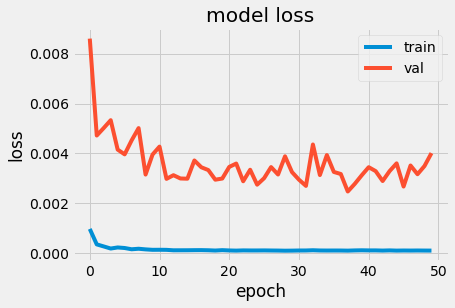

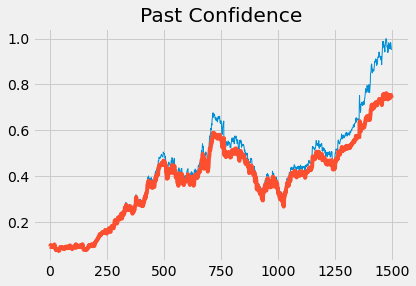

In [112]:
df=pd.read_csv('data/AABA_2006-01-01_to_2018-01-01.csv')
#df=df[df['Name']=='MMM']
series=np.array(df['High'])
model=univariate_ts_rnn(epochs=50,hidden_layers=100, split=0.5)
scaler,model,test_val,predictions=model.train(series)

Epoch 1/100
74/74 - 1s - loss: 0.0846 - mean_absolute_percentage_error: 126.6389 - val_loss: 0.0653 - val_mean_absolute_percentage_error: 29.6068 - 995ms/epoch - 13ms/step
Epoch 2/100
74/74 - 0s - loss: 0.0046 - mean_absolute_percentage_error: 31.6137 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 18.7269 - 195ms/epoch - 3ms/step
Epoch 3/100
74/74 - 0s - loss: 0.0026 - mean_absolute_percentage_error: 24.4462 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 17.3727 - 191ms/epoch - 3ms/step
Epoch 4/100
74/74 - 0s - loss: 0.0022 - mean_absolute_percentage_error: 20.8105 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 14.9687 - 191ms/epoch - 3ms/step
Epoch 5/100
74/74 - 0s - loss: 0.0020 - mean_absolute_percentage_error: 20.7253 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 13.4114 - 193ms/epoch - 3ms/step
Epoch 6/100
74/74 - 0s - loss: 0.0017 - mean_absolute_percentage_error: 17.9770 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 13.3478 - 2

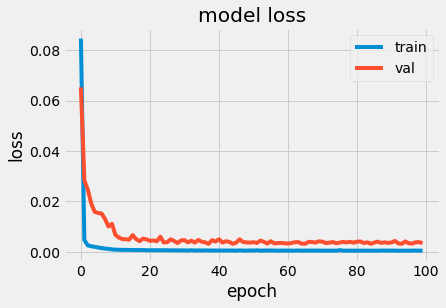

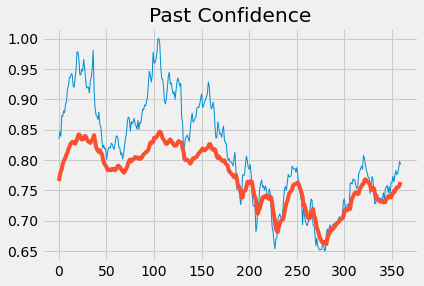

In [113]:
df=pd.read_csv('data/TCS.BO.csv')
series=np.array(df['High'])
model=univariate_ts_rnn(epochs=100,hidden_layers=20)
scaler,model,test_val,predictions=model.train(series)

Epoch 1/500
14/14 - 1s - loss: 0.0594 - mean_absolute_percentage_error: 106050.1406 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 74.2831 - 913ms/epoch - 65ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0252 - mean_absolute_percentage_error: 1427112.6250 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 55.3515 - 94ms/epoch - 7ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0162 - mean_absolute_percentage_error: 592728.2500 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 39.6559 - 91ms/epoch - 6ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0144 - mean_absolute_percentage_error: 725083.2500 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 41.9741 - 83ms/epoch - 6ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0125 - mean_absolute_percentage_error: 703916.9375 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 34.2356 - 89ms/epoch - 6ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0111 - mean_absolute_percentage_error: 422250.4375 - val_loss: 0.0163 - val_mean_absolute_percentag

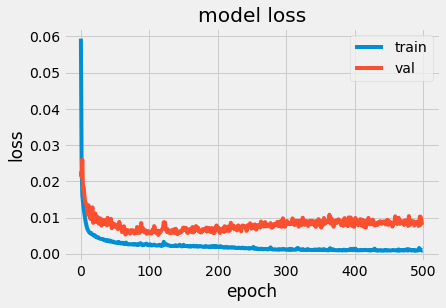

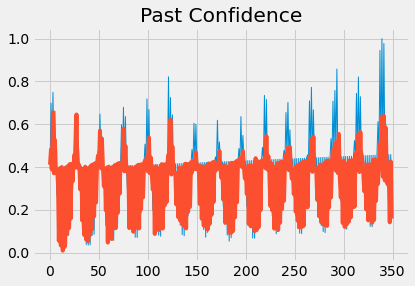

In [114]:
model=univariate_ts_rnn(epochs=500)
df=pd.read_csv('data/tourist_data.csv')
series=np.array(df)
scaler,model,test_val,predictions=model.train(series)

Epoch 1/500
76/76 - 1s - loss: 0.0161 - mean_absolute_percentage_error: 109.4266 - val_loss: 0.1865 - val_mean_absolute_percentage_error: 52.2058 - 1s/epoch - 19ms/step
Epoch 2/500
76/76 - 0s - loss: 7.2804e-04 - mean_absolute_percentage_error: 35.9539 - val_loss: 0.1538 - val_mean_absolute_percentage_error: 47.0353 - 214ms/epoch - 3ms/step
Epoch 3/500
76/76 - 0s - loss: 5.4152e-04 - mean_absolute_percentage_error: 26.2478 - val_loss: 0.1273 - val_mean_absolute_percentage_error: 42.3880 - 211ms/epoch - 3ms/step
Epoch 4/500
76/76 - 0s - loss: 4.1877e-04 - mean_absolute_percentage_error: 20.2860 - val_loss: 0.1095 - val_mean_absolute_percentage_error: 39.1123 - 213ms/epoch - 3ms/step
Epoch 5/500
76/76 - 0s - loss: 3.4916e-04 - mean_absolute_percentage_error: 17.0100 - val_loss: 0.0906 - val_mean_absolute_percentage_error: 35.1185 - 215ms/epoch - 3ms/step
Epoch 6/500
76/76 - 0s - loss: 2.9216e-04 - mean_absolute_percentage_error: 15.2220 - val_loss: 0.0836 - val_mean_absolute_percentage_e

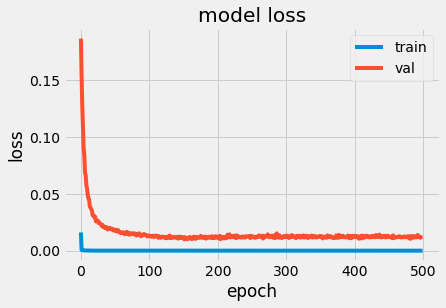

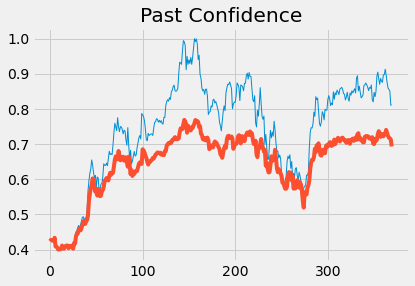

In [115]:
model=univariate_ts_rnn(epochs=500)
df=pd.read_csv('data/portfolio_data.csv')
series=np.array(df['NFLX'])
scaler,model,test_val,predictions=model.train(series)

In [116]:
len(test_val)
len(predictions)

370

In [3]:
import numpy as np

In [73]:
def get_XY(dat, time_steps):
            dat=np.array(dat)
            Y_ind = np.arange(time_steps, int((len(dat)//time_steps)*time_steps),1)
            #Y_ind=np.arange(range(time_steps-1,len(dat)))
            Y = dat[Y_ind]
            rows_x = len(Y)
            X=[]
            for i in Y_ind:
                #if i!=Y_ind[len(Y_ind)-1] :
                X.append(dat[i-time_steps:i])
            #X = dat[range(time_steps*rows_x)]
            X=np.array(X)
            X = np.reshape(X, (rows_x, time_steps, 1))    
            return X, Y

In [76]:
a=[9,2,4,2,4,3,4,2,4,2,4,2,3,4,5,2,6,8,0,3,5,7,1,4,7]
x,y=get_XY(a,10)
len(y)

10

In [69]:
def get_XY(dat, time_steps):
            dat=np.array(dat)
            Y_ind = np.arange(time_steps, len(dat), time_steps)
            Y = dat[Y_ind]
            rows_x = len(Y)
            X = dat[range(time_steps*rows_x)]
            #X = np.reshape(X, (rows_x, time_steps, 1))    
            return X, Y

In [52]:
a=[9,2,4,2,4,3,4,2,4,2,4,2,3,4,5,2,6,8,0,3,5,7,1,4,7]
get_XY(a,4)

(array([9, 2, 4, 2, 4, 3, 4, 2, 4, 2, 4, 2, 3, 4, 5, 2, 6, 8, 0, 3, 5, 7,
        1, 4]),
 array([4, 4, 3, 6, 5, 7]))

In [56]:
np.arange(6, int((len(a)//6)*6),1)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])

In [25]:
a=np.array(a)
a[np.arange(4, int((len(a)//4)*4),1)]

array([4, 3, 4, 2, 4, 2, 4, 2, 3, 4, 5, 2, 6, 8, 0, 3, 5, 7, 1, 4])